In [1]:
from time import time

class Timer(object):
  def __init__(self, verbose=False):
    self.verbose = verbose  

  def __enter__(self):
    self.start = time()
    return self

  def __exit__(self, *args):
    self.end = time()
    self.secs = self.end - self.start
    self.msecs = self.secs * 1000  # millisecs
    if self.verbose:
      print 'elapsed time: %f ms' % self.msecs

In [2]:
import matplotlib as plt
import numpy as np
 
def plot_feature_scores(coef, vocab, index=0):
    markers = ["o", "x"]
    
    figsize(20,8)

    important = np.argsort(np.abs(coef))[-50:]
    important_feature_names = np.array([vocab[idx] for idx in important])
    important_feature_values = coef[important]
    inds = np.argsort(important_feature_values)[::-1]
    important_feature_names = important_feature_names[inds]
    important_feature_values = important_feature_values[inds]
    ylabel("weight")

    ax = plt.gca()
    ax.set_xticks(np.arange(len(important_feature_values)))
    labels = ax.set_xticklabels(important_feature_names)
    plt.setp(labels, rotation=90)
    #plt.plot(important_feature_values, marker="o", c=cm.jet)
    plt.scatter(np.arange(len(important_feature_values)), important_feature_values, c=important_feature_values,marker=markers[index], cmap=cm.autumn)
    print("done")

In [3]:
from os import listdir
from os.path import isfile, join
docLabels = []
docLabels = [f for f in listdir("data/instagram_activities/") if '.csv' in f]

print 'documents:', len(docLabels)
print docLabels

documents: 11
['instagram_activities.csv.0', 'instagram_activities.csv.1', 'instagram_activities.csv.10', 'instagram_activities.csv.2', 'instagram_activities.csv.3', 'instagram_activities.csv.4', 'instagram_activities.csv.5', 'instagram_activities.csv.6', 'instagram_activities.csv.7', 'instagram_activities.csv.8', 'instagram_activities.csv.9']


In [4]:
import csv

data = []
for doc in docLabels:
    print 'Parsing ', doc
    with open('data/instagram_activities/' + doc, 'rb') as csvfile:
        csvReader = csv.reader(csvfile, delimiter=',', quotechar='"')
        for row in csvReader:
            data.append([row[0], [str(s) for s in eval(row[1])]])
            
print '- - - length:', len(data)

Parsing  instagram_activities.csv.0
Parsing  instagram_activities.csv.1
Parsing  instagram_activities.csv.10
Parsing  instagram_activities.csv.2
Parsing  instagram_activities.csv.3
Parsing  instagram_activities.csv.4
Parsing  instagram_activities.csv.5
Parsing  instagram_activities.csv.6
Parsing  instagram_activities.csv.7
Parsing  instagram_activities.csv.8
Parsing  instagram_activities.csv.9
- - - length: 1005459


In [5]:
import pandas as pd

ratings = pd.read_csv('data/instagram_ratings.csv', header=None)
# ratings['docvecs']     = ratings[0].apply(lambda x: model.docvecs[str(x)])
# ratings['docvecs_len'] = ratings['docvecs'].apply(lambda x: len(x))

# ratings = ratings[ratings['docvecs_len'] == 300]
# ratings = ratings.reset_index(drop=True)

print '- - - length:', len(ratings)

- - - length: 3436


In [6]:
for index, item in ratings.iterrows():
    data.append([item[2],['rule_' + str(item[4]), str(item[0])]])

print data[0]
print '- - - length:', len(data)
print data[-1]

["We went from the sea to the vineyards this week. Oregon is so amazing, I'm glad we decided to stay close to home this week. Technically it was Jeff who was on spring break but I felt like I was on spring break too. Back to life, back to reality. // #traveloregon #sevenwonders #oregoncoast #samandjeffvacay #latergram #vscocam #darlingweekend", ['rule_3616', '443640355379747219']]
- - - length: 1008895
['When you ride the train like a BOSS \xf0\x9f\x92\x81\xf0\x9f\x8f\xbd', ['rule_3744', '443640355579665515']]


In [7]:
import re

def select_hashtags(text):
    text_array = re.compile("(\W)").split(text)
    result = []
    index = 0
    for item in text_array:
        if item == '#':
            result.append(item + text_array[index + 1])
        index += 1
    return result

def filter_hashtags(data):
    if type(data[0]) != str or len(data[0]) == 0: return False
    return True

In [8]:
import gensim
import re

data = filter(filter_hashtags, data)

sentences = [re.findall(r"#[a-zA-Z\d]+", doc[0]) for doc in data]

Couldn't import dot_parser, loading of dot files will not be possible.


In [10]:
model = gensim.models.Word2Vec(size=100, window=5, min_count=1, workers=6)
model.build_vocab(sentences)

for epoch in range(10):
    with Timer() as t:
        model.train(sentences)
        model.alpha -= 0.002 # decrease the learning rate
        model.min_alpha = model.alpha # fix the learning rate, no deca
        model.train(sentences)
    print "Trainning time for epoch", epoch, "is", t.secs

Trainning time for epoch 0 is 141.674429893
Trainning time for epoch 1 is 135.371546984
Trainning time for epoch 2 is 134.255045891
Trainning time for epoch 3 is 134.477659941
Trainning time for epoch 4 is 129.320814133
Trainning time for epoch 5 is 128.593387127
Trainning time for epoch 6 is 131.078907967
Trainning time for epoch 7 is 130.397448063
Trainning time for epoch 8 is 135.470386982
Trainning time for epoch 9 is 138.084217072


In [9]:
# model.save('1M_10epochs_hashtags')

import gensim

model = gensim.models.Word2Vec.load('1M_10epochs_hashtags')

In [10]:
model.similarity('#trinkithunter', '#store')

0.10370708920537587

In [11]:
ratings = ratings.dropna(subset=[2])

ratings.ix[pd.isnull(ratings[3]), 3] = 'good'

In [18]:
def distance(array):
    _itens = 0
    _sum = 0
    _min = 1000
    _max = 0

    if len(array) <= 1:
        return 0,0,0

    for i1 in range(0, len(array)):
        for i2 in range(0, len(array)):
            if i1 == i2: 
                continue

            r = 0
            try:
              r = model.similarity(array[i1], array[i2])
              _sum += r
              if r > _max:
                  _max = r
              if r < _min: 
                  _min = r

              _itens += 1
            except:
              continue
    if _itens == 0: 
      return 0, 0, 0
    else:
      return _min, _max, _sum/_itens

min_series, max_series, avg_series = [], [], []
for index, hashtags in ratings.iterrows():
    related = select_hashtags(hashtags[2])
    _min, _max, _avg = distance(related)

    min_series.append(_min)
    max_series.append(_max)
    avg_series.append(_avg)

In [19]:
ratings['min_distance'] = min_series
ratings['max_distance'] = max_series
ratings['avg_distance'] = avg_series

In [20]:
ratings.columns = ['id', 'bool_feedback', 'body', 'feedback', 'rule_id', 'min_distance', 'max_distance', 'avg_distance']
ratings.head()

,id,bool_feedback,body,feedback,rule_id,min_distance,max_distance,avg_distance
0,443640355381423154,True,BEST Blood Orange Martini #soeventful #sonomac...,good,4452,0.290545,0.786271,0.520897
1,443640355381477385,False,The thug life chose me😔\n#thuglife #curlyhair...,others,4452,-0.116658,0.838836,0.212296
2,443640355386138910,False,"Today's Location: Latourell Falls, Oregon\n\nP...",bad_user,3616,-0.042473,0.884672,0.499139
3,443640355386037764,False,Good morning صبحكم الله بالخير,bad_user,3616,0.000000,0.000000,0.000000
4,443640355388094068,True,"STUD 21 executes a ""Sandbox Departure"" from Bu...",good,4668,0.123513,0.936367,0.502234


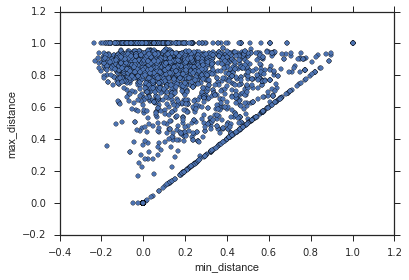

In [89]:
import matplotlib.pyplot as plt

ratings.plot(kind='scatter', x='min_distance', y='max_distance');

In [90]:
ratings.groupby([3]).agg(['count'])

,0,1,2,4,min_distance,max_distance,avg_distance
,count,count,count,count,count,count,count
3,,,,,,,
bad_user,14,14,14,14,14,14,14
content_not_relevant,921,921,921,921,921,921,921
high_volume,1,1,1,1,1,1,1
inappropriate_content,9,9,9,9,9,9,9
others,162,162,162,162,162,162,162
spam,290,290,290,290,290,290,290
technical_issues,338,338,338,338,338,338,338


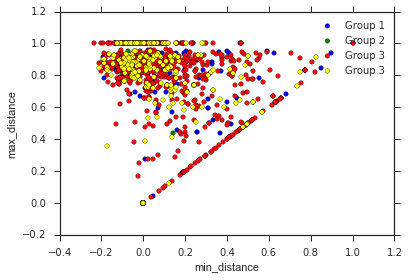

In [91]:
ax = ratings[ratings[3] == 'others'].plot(kind='scatter', x='min_distance', y='max_distance', color='Blue', label='Group 1'); 

ratings[ratings[3] == 'bad_user'].plot(kind='scatter', x='min_distance', y='max_distance', color='Green', label='Group 2', ax=ax);

ratings[ratings[3] == 'content_not_relevant'].plot(kind='scatter', x='min_distance', y='max_distance', color='Red', label='Group 3', ax=ax);

ratings[ratings[3] == 'spam'].plot(kind='scatter', x='min_distance', y='max_distance', color='Yellow', label='Group 3', ax=ax);

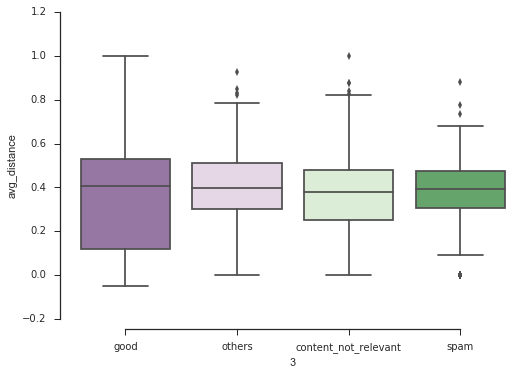

In [98]:
import seaborn as sns
sns.set(style="ticks")

# Draw a nested boxplot to show bills by day and sex
sns.boxplot(x=3, y="avg_distance", data=ratings[ratings[3].isin(['others','spam','content_not_relevant', 'good'])], palette="PRGn")
sns.despine(offset=10, trim=True)

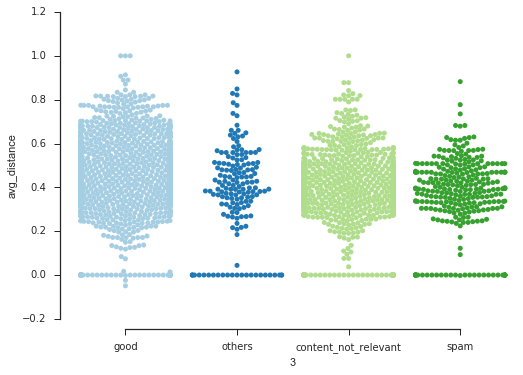

In [99]:
import seaborn as sns
sns.set(style="ticks")

# Draw a nested boxplot to show bills by day and sex
# sns.swarmplot(x=3, y="avg_distance", data=ratings[ratings[3].isin(['others','spam','content_not_relevant'])], palette="PRGn")
sns.swarmplot(x=3, y="avg_distance", data=ratings[ratings[3].isin(['others','spam','content_not_relevant','good'])], palette="Paired")
sns.despine(offset=10, trim=True)

In [23]:
train = ratings[ratings['feedback'].isin(['spam','good'])]

train.loc[:, 'result'] = train.loc[:, 'feedback'].isin(['spam','content_not_relevant'])
train.loc[:, 'result'] = train.result.astype(int)

train.loc[:, 'hashtag_count'] = train.loc[:, 'body'].apply(lambda x: len(select_hashtags(x)))
train.loc[:, 'words_count'] = train.loc[:, 'body'].apply(lambda x: len(x.split()))
train.loc[:, 'characters_count'] = train.loc[:, 'body'].apply(lambda x: len(x) )
train.loc[:, 'uppercase_letters'] = train.loc[:, 'body'].apply(lambda x: sum(1 for c in x if c.isupper()) )
train.loc[:, 'non_alpha_characters_count'] = train.loc[:, 'body'].apply(lambda x: sum(not c.isalnum() for c in x) )

train_columns = ['min_distance', 'max_distance', 'avg_distance', 'hashtag_count', 
                 'words_count', 'characters_count', 'uppercase_letters', 'non_alpha_characters_count']

result_column = ['result']

/Users/felipeclopes/Projects/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:266: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/felipeclopes/Projects/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:426: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [24]:
data = train[ratings['feedback'].isin(['spam'])]
print 'spam:', len(data)
data = data.append(train[ratings['feedback'].isin(['good'])].head(len(data) * 2))
print 'total:', len(data)
data = data.dropna(subset=['body'])

/Users/felipeclopes/Projects/anaconda/lib/python2.7/site-packages/pandas/core/frame.py:1997: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "DataFrame index.", UserWarning)


spam: 290
total: 870


Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


- Starting: Mon Apr  4 10:44:34 2016
[[275  25]
 [ 79  56]]
#### SCORE:0.76091954023
done
- Starting: Mon Apr  4 10:44:34 2016
[[248  32]
 [ 86  69]]
#### SCORE:0.728735632184
done


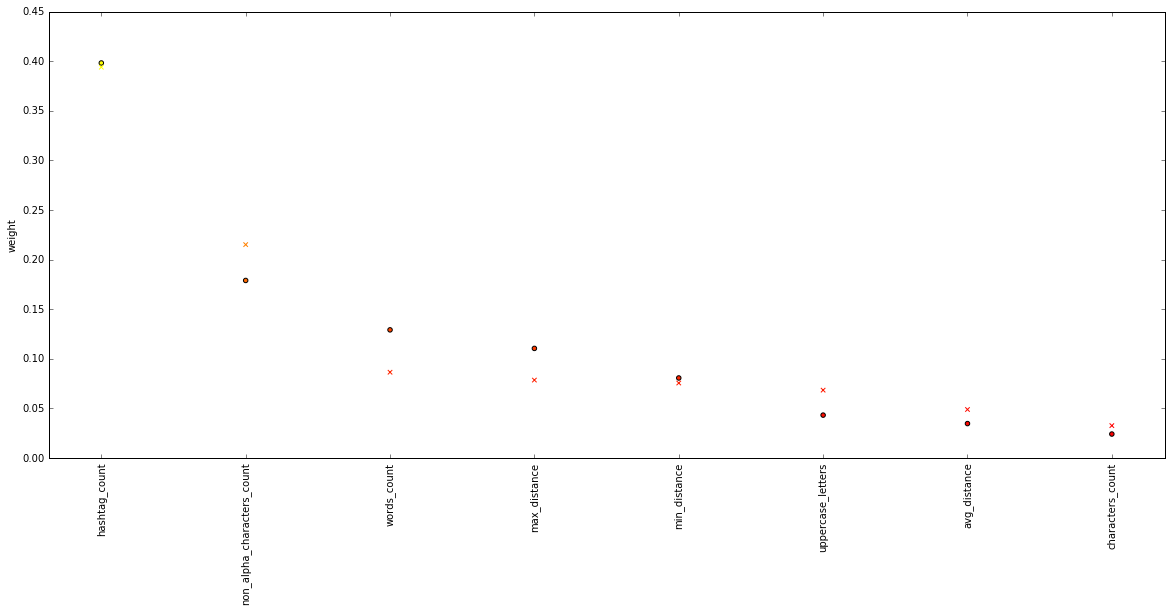

In [28]:
%pylab inline

from sklearn import svm
from sklearn.cross_validation import KFold
from sklearn.metrics import confusion_matrix
from time import ctime

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

import numpy as np

k_fold = KFold(n=len(data), n_folds=2, shuffle=True)
b_scores, svc_scores = [], []

#x_data = np.array(X)
x_data = np.array(data[train_columns].values)
y_data = np.array(data.result)

i = 0

for tr_indices, cv_indices in k_fold:
    tr    = x_data[tr_indices]
    cv    = x_data[cv_indices]

    tr_y  = y_data[tr_indices]
    cv_y  = y_data[cv_indices]

    clf = DecisionTreeClassifier(min_samples_split=5, max_depth=5)
    
    print '- Starting:', ctime()
    clf.fit(tr, tr_y)
    print(confusion_matrix(cv_y, clf.predict(cv)))    
    print('#### SCORE:' + str(clf.score(cv, cv_y)))
    
    plot_feature_scores(clf.feature_importances_, train_columns, i)
    i += 1

In [29]:
trained = train

trained.loc[:, 'predicted_result'] = clf.predict(trained[train_columns])

In [30]:
misclassifications = trained[trained['result'] != trained['predicted_result']].head()

In [32]:
misclassifications[train_columns + ['body', 'result', 'predicted_result']].iloc[1]

min_distance                                                   0.777657
max_distance                                                   0.777657
avg_distance                                                   0.777657
hashtag_count                                                         2
words_count                                                           5
characters_count                                                     41
uppercase_letters                                                     4
non_alpha_characters_count                                            6
body                          Monday morning motivation #Brabus #GWagon
result                                                                0
predicted_result                                                      1
Name: 38, dtype: object

In [145]:
import pydot
from sklearn import tree

with open('tree.dot', 'w') as dotfile:
    tree.export_graphviz(clf, out_file=dotfile, feature_names = train_columns)

In [37]:
print data.isnull().sum()

id                            0
bool_feedback                 0
body                          0
feedback                      0
rule_id                       0
min_distance                  0
max_distance                  0
avg_distance                  0
result                        0
hashtag_count                 0
words_count                   0
characters_count              0
uppercase_letters             0
non_alpha_characters_count    0
dtype: int64


Best score: 0.745
Best parameters set:
	body_tfidf__max_features: 500
	body_tfidf__min_df: 5
	tree__max_depth: 5
	tree__min_samples_split: 10
508
508
done


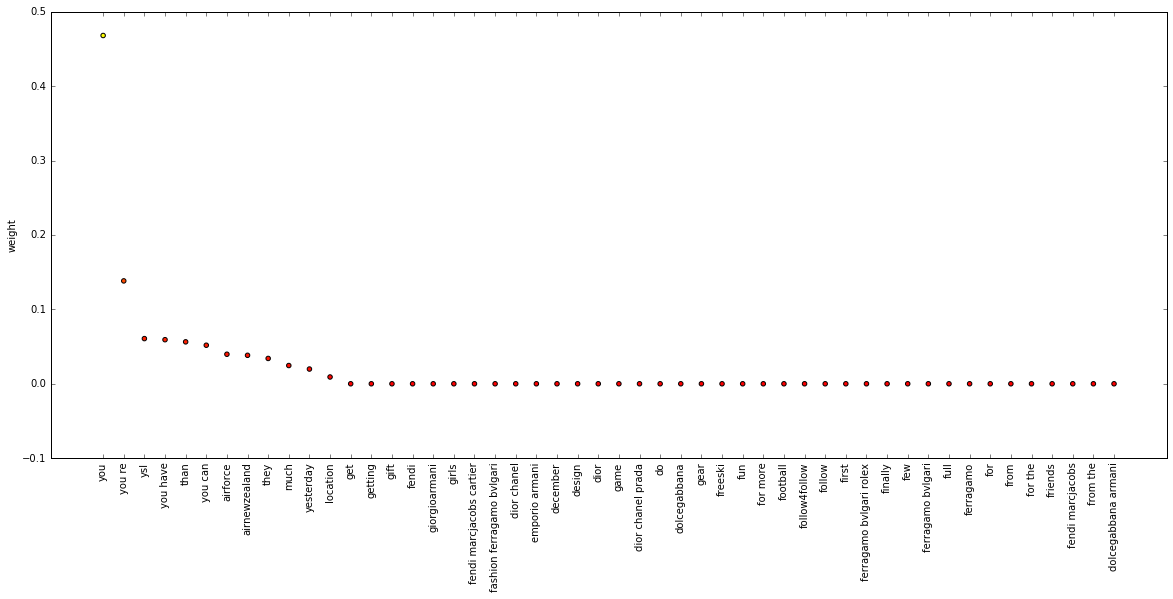

In [87]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.grid_search import GridSearchCV

pipeline = Pipeline([
#                     ("debugger1", Debugger('Start')),
                    ("body_tfidf", DataFrameTfidfVectorizer(col='body', 
                                            prefix="body",
                                            ngram_range=(1, 3), 
                                            analyzer="word",
                                            binary=True, #False
                                            min_df = 5)),
                    ("drop_text_cols", DropColumnsTransformer(['body'])),
                    ("nparray", NumpyArrayTransformer()),
#                     ("debugger8", Debugger('Finish')),
                    ('tree', DecisionTreeClassifier())])

parameters = {
    'body_tfidf__min_df': (2, 5, 10),
    'body_tfidf__max_features': (50, 500, 1000),
    'tree__max_depth': (5, 10, 15),  # unigrams or bigrams
    'tree__min_samples_split': (2, 5, 10)
}

k_fold = KFold(n=len(data), n_folds=3, shuffle=True)
grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, cv=k_fold)

grid_train = data.loc[:, train_columns + ['body']].copy()
grid_result = data[result_column].values

print("Performing grid search...")
print("pipeline:", [name for name, _ in pipeline.steps])
print("parameters:", parameters)
t0 = time()
grid_search.fit(grid_train, grid_result)
print("done in %0.3fs" % (time() - t0))
print()

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

best_pipeline = Pipeline([
                    ('body_lowercase', TextToLowerCase(cols=['body'])),

                    ('number_mentions', NumberOfMentions(cols='body')),
                    ('number_hashtags', NumberOfHashtags(cols='body')),
                    ('number_periods', NumberOfPeriods(cols='body')),
        
                    ('number_words', NumberOfWords(cols='body')),
                    ('number_camel_words', NumberCamelCaseWords(cols='body')),
                    ('number_words_per_period', AvgWordsPerPeriod(cols='body')),        

                    ('number_uppercase_chars', NumberUpperCaseChars(cols='body')),
                    ('number_punctuation_chars', NumberNonAlphaNumChars(cols='body')),
                    
                    ("body_tfidf", DataFrameTfidfVectorizer(col='body', 
                                            prefix="body",
                                            ngram_range=(1, 3), 
                                            analyzer="word",
                                            binary=True, #False
                                            min_df = 5,
                                            max_features = 500)),
                    ("drop_text_cols", DropColumnsTransformer(['body'])),
                    ("nparray", NumpyArrayTransformer()),
                    ('tree', DecisionTreeClassifier(max_depth = 5, min_samples_split = 10))])
best_pipeline.fit(grid_train, grid_result)

print len(best_pipeline.named_steps['tree'].feature_importances_)
print len(train_columns + best_pipeline.named_steps['body_tfidf'].get_feature_names())

plot_feature_scores(best_pipeline.named_steps['tree'].feature_importances_, train_columns + best_pipeline.named_steps['body_tfidf'].get_feature_names(), 0)

In [89]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.base import BaseEstimator

class DataFrameTfidfVectorizer(TfidfVectorizer):

  def __init__(self, col, prefix=None, input='content', encoding='utf-8',
               decode_error='strict', strip_accents=None, lowercase=True,
               preprocessor=None, tokenizer=None, analyzer='word',
               stop_words=None, token_pattern=r"(?u)\b\w\w+\b",
               ngram_range=(1, 1), max_df=1.0, min_df=1,
               max_features=None, vocabulary=None, binary=False,
               dtype=np.int64, norm='l2', use_idf=True, smooth_idf=True,
               sublinear_tf=False):
      super(DataFrameTfidfVectorizer, self).__init__(
          input=input, encoding=encoding, decode_error=decode_error,
          strip_accents=strip_accents, lowercase=lowercase,
          preprocessor=preprocessor, tokenizer=tokenizer, analyzer=analyzer,
          stop_words=stop_words, token_pattern=token_pattern,
          ngram_range=ngram_range, max_df=max_df, min_df=min_df,
          max_features=max_features, vocabulary=vocabulary, binary=binary,
          dtype=dtype)

      self.col = col
      self.prefix = prefix or col
      
  def treat_special_char(self, c):
    try:
      encoding = chardet.detect(str(c))['encoding'] or "KOI8-R"
      return '0' if c.isdigit() else c.decode(encoding)
    except:        
      return '9'

  def treat_special_chars(self, col):
    col.fillna("null", inplace=True)
    col = [''.join([self.treat_special_char(c) for c in list(n)]) 
           for n in col.values]
    return col

  def fit(self, dataframe, y=None):
    dataframe = dataframe.copy()
    dataframe[self.col] = self.treat_special_chars(dataframe[self.col])
    super(DataFrameTfidfVectorizer, self).fit(dataframe[self.col])
    return self

  def fit_transform(self, dataframe, y=None):
    dataframe = dataframe.copy()
    dataframe[self.col] = self.treat_special_chars(dataframe[self.col])
    field_matrix = super(DataFrameTfidfVectorizer, self).fit_transform(dataframe[self.col])
    features_names = map(lambda f: "_".join([self.prefix,f]), super(DataFrameTfidfVectorizer, self).get_feature_names())
    field_df = pd.DataFrame(field_matrix.A, columns=features_names)

    dataframe = dataframe.join(field_df)

    return dataframe

  def transform(self, dataframe, copy=True):
    dataframe = dataframe.copy()
    dataframe[self.col] = self.treat_special_chars(dataframe[self.col])
    field_matrix = super(DataFrameTfidfVectorizer, self).transform(dataframe[self.col])
    features_names = map(lambda f: "_".join([self.prefix,f]), super(DataFrameTfidfVectorizer, self).get_feature_names())
    field_df = pd.DataFrame(field_matrix.A, columns=features_names)

    dataframe = dataframe.join(field_df)

    return dataframe

class TextToLowerCase(BaseEstimator, TransformerMixin):

  def __init__(self, cols):
    self.cols = cols

  def fit(self, X, y=None):
    return self

  def transform(self, X, y=None):
    for c in self.cols:
      if c in X:
        X[c] = [t.lower() for t in X[c].values]
    return X


class NumberOfWords(BaseEstimator, TransformerMixin):

  def __init__(self, cols):
    self.cols = cols

  def fit(self, X, y=None):
    return self

  def transform(self, X, y=None):
    for c in self.cols:
      if c in X:
        X["number_of_words_in_"+c] = [len(t.split(' ')) for t in X[c].values]
    return X


class NumberNonAlphaNumChars(BaseEstimator, TransformerMixin):

  def __init__(self, cols):
    self.cols = cols

  def fit(self, X, y=None):
    return self

  def transform(self, X, y=None):
    for c in self.cols:
      if c in X:
        X["number_of_non_alphanum_in_"+c] = [len(re.sub(r"[\w\d]","", t)) for t in X[c].values]
    return X


class NumberUpperCaseChars(BaseEstimator, TransformerMixin):

  def __init__(self, cols):
    self.cols = cols

  def fit(self, X, y=None):
    return self

  def transform(self, X, y=None):
    for c in self.cols:
      if c in X:
        X["number_of_upper_case_chars_in_"+c] = [len(re.sub(r"[^A-Z]","", t)) for t in X[c].values]
    return X


class NumberCamelCaseWords(BaseEstimator, TransformerMixin):

  def __init__(self, cols):
    self.cols = cols

  def fit(self, X, y=None):
    return self

  def transform(self, X, y=None):
    for c in self.cols:
      if c in X:
        X["number_of_camel_case_words_in_"+c] = [len(re.findall(r"^[A-Z][a-z]|\s[A-Z][a-z]", t)) 
                                                 for t in X[c].values]
    return X


class NumberOfMentions(BaseEstimator, TransformerMixin):

  def __init__(self, cols):
    self.cols = cols

  def fit(self, X, y=None):
    return self

  def transform(self, X, y=None):
    for c in self.cols:
      if c in X:
        X["number_of_mentions_in_"+c] = [len(re.findall(r"\s@[a-zA-Z]",t)) 
                                                 for t in X[c].values]
    return X

class NumberOfHashtags(BaseEstimator, TransformerMixin):

  def __init__(self, cols):
    self.cols = cols

  def fit(self, X, y=None):
    return self

  def transform(self, X, y=None):
    for c in self.cols:
      if c in X:
        X["number_of_mentions_in_"+c] = [len(re.findall(r"#[a-zA-Z\d]+",t)) 
                                                 for t in X[c].values]
    return X

class NumberOfPeriods(BaseEstimator, TransformerMixin):

  def __init__(self, cols):
    self.cols = cols

  def fit(self, X, y=None):
    return self

  def transform(self, X, y=None):
    for c in self.cols:
      if c in X:
        X["number_of_periods_in_"+c] = [len(t.split(". ")) 
                                        for t in X[c].values]
    return X

class AvgWordsPerPeriod(BaseEstimator, TransformerMixin):

  def __init__(self, cols):
    self.cols = cols

  def fit(self, X, y=None):
    return self

  def transform(self, X, y=None):
    for c in self.cols:
      if c in X:
        X["avg_words_per_period_in_"+c] = [np.mean([len(p.split(" ")) for p in t.split(". ")]) 
                                            for t in X[c].values]
    return X

class DropColumnsTransformer(BaseEstimator, TransformerMixin):

  def __init__(self, cols):
    self.cols = cols

  def fit(self, X, y=None):
    return self

  def transform(self, X, y=None):
    X = X.copy()
    for c in self.cols:
      if c in X:
        X.drop([c], axis=1, inplace=True)
    return X


class NumpyArrayTransformer(BaseEstimator, TransformerMixin):

  def fit(self, X, y=None):
    return self

  def transform(self, X, y=None):
    X = X.copy()
    X = X.reindex_axis(sorted(X.columns), axis=1)
    X.fillna(0, inplace=True)
    return np.asarray(X)


class Debugger(BaseEstimator, TransformerMixin):
  def __init__(self, name=""):
      self.name = name

  def fit(self, X, y=None):
      return self

  def transform(self, X, y=None):
      print self.name, '-', ctime(), X.shape
      return X